In [1]:
# Standard libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import iris
from iris.pandas import as_cubes
import sys

from datetime import datetime
from cartopy.util import add_cyclic_point
import gc
import imageio.v2
from IPython import display
import netCDF4
from global_land_mask import globe
# # Import tobac itself:
import tobac

# Disable a few warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

/glade/work/noteng/conda-envs/tobac-env/lib/python3.11/site-packages/tobac/utils/internal.py:448: UserWarning: Numba not able to be imported; periodic boundary calculations will be slower.Exception raised: ModuleNotFoundError("No module named 'numba'")
  warnings.warn(
/glade/work/noteng/conda-envs/tobac-env/lib/python3.11/site-packages/tobac/utils/internal.py:448: UserWarning: Numba not able to be imported; periodic boundary calculations will be slower.Exception raised: ModuleNotFoundError("No module named 'numba'")
  warnings.warn(


In [2]:
%%time
path = '/glade/u/home/noteng/work/masters-research/data/'
file = 'march13-march14.nc'
data = xr.open_dataset(path+file)
data = data.sel(time=slice('2020-03-13T04:00:00.000000000', '2020-03-14T05:00:00.000000000'))
data.close()

CPU times: user 41.6 ms, sys: 19.4 ms, total: 61 ms
Wall time: 235 ms


### equivalent reflectivity factor

In [3]:
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,450:580,256:771] #Based on longitude and latitude of Andoya and Norwegian Sea
equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,250:650,450:850] #Based on longitude and latitude of Andoya and Norwegian Sea
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor'][:,330:580,660:780] #### hdm1 and hdm2
# equivalent_reflectivity_factor = data['equivalent_reflectivity_factor']
equivalent_reflectivity_factor

<xarray.DataArray 'equivalent_reflectivity_factor' (time: 301, Yc: 400, Xc: 400)>
[48160000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14T05:00:00
  * Xc       (Xc) float32 -8.3e+04 -8.2e+04 -8.1e+04 ... 3.15e+05 3.16e+05
  * Yc       (Yc) float32 -2.06e+06 -2.061e+06 ... -2.458e+06 -2.459e+06
    lon      (Yc, Xc) float32 ...
    lat      (Yc, Xc) float32 ...
Attributes:
    standard_name:  equivalent_reflectivity_factor
    long_name:      Radar Reflectivity
    units:          dBZ
    grid_mapping:   projection_lambert

### convert equivalent reflectivity factor to Iris cube

In [4]:
%%time
ERF = equivalent_reflectivity_factor.to_iris()
ERF

CPU times: user 3.97 s, sys: 229 ms, total: 4.2 s
Wall time: 4.47 s


Equivalent Reflectivity Factor (dBZ),time,projection_y_coordinate,projection_x_coordinate
Shape,301,400,400
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
latitude,-,x,x
longitude,-,x,x


In [5]:
%%time
# Determine temporal and spatial sampling of the input data:
#grid_spacing = 1km... but tobac uses meters... 1000m = 1km
#time_spacing = 5 minutes time resolution... tobac uses seconds..... 
#since our time_spacing is 5 min, we get our time spacing in seconds.. if 60 sec = 1 min? then 5 mins = 300s... so time-spacing is 300
dxy,dt=tobac.utils.get_spacings(ERF, grid_spacing=1000, time_spacing=300)  #tobac detect it by default
dxy, dt 

CPU times: user 58 µs, sys: 0 ns, total: 58 µs
Wall time: 61.5 µs


(1000, 300)

# DETECTION FEATURE

In [6]:
%%time
# threshold = np.arange(5, 20.1, 1)
threshold = [10]
parameters_features = {}
parameters_features['target'] = 'maximum'
parameters_features['threshold'] = threshold
parameters_features['n_min_threshold'] = 0 #set to zero or one always; 
parameters_features['n_erosion_threshold'] = 0 #another filtering/smoothing method.
parameters_features['position_threshold'] ='weighted_diff'
parameters_features['sigma_threshold'] = 1 #smoothing data
# parameters_features['min_distance'] = 15

# Using 'center' here outputs the feature location as the arithmetic center of the detected feature
Features = tobac.feature_detection_multithreshold(field_in=ERF, dxy=dxy, **parameters_features)

CPU times: user 4 s, sys: 5.57 ms, total: 4.01 s
Wall time: 4.25 s


In [7]:
%%time
Features.head()

CPU times: user 87 µs, sys: 0 ns, total: 87 µs
Wall time: 90.1 µs


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude
0,0,1,84.600598,399.000000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036
1,0,2,101.255095,389.000000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626
2,0,3,110.790944,214.751230,88,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.170791e+06,131751.230492,70.426595,13.473177
3,0,4,112.472423,381.827530,14,10,4,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991
4,0,5,124.862389,387.370633,29,10,5,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.184862e+06,304370.633345,70.142970,17.930767


In [8]:
Features.to_csv('../saved-files/threshold-10/Features-10.csv', index=False)

# SEGMENTATION

In [9]:
%%time
# Keyword arguments for the segmentation step:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=10

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [10]:
%%time
# Perform segmentation and save results to files:
Mask_ERF, Features_ERF = tobac.segmentation_2D(Features,ERF,dxy,**parameters_segmentation)

CPU times: user 47.9 s, sys: 340 ms, total: 48.2 s
Wall time: 50.4 s


In [11]:
type(Mask_ERF)

iris.cube.Cube

In [12]:
iris.save(Mask_ERF, '../saved-files/threshold-10/Mask_ERF_iris-10.nc')

In [13]:
%%time
Mask_ERF

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


Segmentation Mask (1),time,projection_y_coordinate,projection_x_coordinate
Shape,301,400,400
Dimension coordinates,,,
time,x,-,-
projection_y_coordinate,-,x,-
projection_x_coordinate,-,-,x
Auxiliary coordinates,,,
latitude,-,x,x
longitude,-,x,x


In [14]:
%%time
# Convert the segmentation data from iris cube to DataArray
segmented_data = xr.DataArray.from_iris(Mask_ERF)
segmented_data

CPU times: user 4.98 ms, sys: 0 ns, total: 4.98 ms
Wall time: 4.98 ms


<xarray.DataArray 'segmentation_mask' (time: 301, Yc: 400, Xc: 400)>
[48160000 values with dtype=int32]
Coordinates:
  * time     (time) datetime64[ns] 2020-03-13T04:00:00 ... 2020-03-14T05:00:00
  * Yc       (Yc) float32 -2.06e+06 -2.061e+06 ... -2.458e+06 -2.459e+06
  * Xc       (Xc) float32 -8.3e+04 -8.2e+04 -8.1e+04 ... 3.15e+05 3.16e+05
    lat      (Yc, Xc) float32 ...
    lon      (Yc, Xc) float32 ...
Attributes:
    long_name:  segmentation_mask

In [15]:
segmented_data.to_netcdf('../saved-files/threshold-10/segmented_ERF-xr-10.nc')

# TRAJECTORY LINKING

In [16]:
%%time
# keyword arguments for linking step
parameters_linking={}
parameters_linking['v_max']=10
parameters_linking['stubs']=1
parameters_linking['order']=1
parameters_linking['extrapolate']=0 
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=15
parameters_linking['method_linking']= 'predict'
# parameters_linking['time_cell_min'] = 10

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


In [17]:
%%time
# Track=tobac.linking_trackpy(Features, ERF, dt=dt, dxy=dxy, **parameters_linking)
Track = tobac.linking_trackpy(Features, ERF, dt=dt, dxy=dxy, **parameters_linking)

Frame 300: 41 trajectories present.
CPU times: user 2.15 s, sys: 22.1 ms, total: 2.17 s
Wall time: 2.85 s


In [18]:
Track.to_csv('../saved-files/threshold-10/Track-10.csv', index=False)

In [19]:
# latA = 69.141281 #latitude of COMBLE site
# lonA = 15.684166-1 #longitude of COMBLE site -1

<h1 style="color:red;">TRACKED INFO</h1>

In [19]:
Track

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,1,84.600598,399.000000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036,1,0 days 00:00:00
1,0,2,101.255095,389.000000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626,2,0 days 00:00:00
2,0,3,110.790944,214.751230,88,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.170791e+06,131751.230492,70.426595,13.473177,3,0 days 00:00:00
3,0,4,112.472423,381.827530,14,10,4,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991,4,0 days 00:00:00
4,0,5,124.862389,387.370633,29,10,5,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.184862e+06,304370.633345,70.142970,17.930767,5,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24636,300,37,310.061166,275.174586,7,10,24637,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.370061e+06,192174.585806,68.576861,14.635643,8205,0 days 02:00:00
24637,300,38,335.506830,249.378646,19,10,24638,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.395507e+06,166378.645933,68.362972,13.973067,8380,0 days 00:55:00
24638,300,39,338.000000,240.000000,1,10,24639,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.398000e+06,157000.000000,68.346031,13.745879,8505,0 days 00:00:00
24639,300,40,345.289261,230.420788,113,10,24640,2020-03-14 05:00:00,2020-03-14 05:00:00,-2.405289e+06,147420.787679,68.285155,13.507285,8480,0 days 00:15:00


In [20]:
%%time
track = Track.sort_values(['cell', 'time_cell'])
track = track.reset_index(drop=True)
track.head()

CPU times: user 7.52 ms, sys: 0 ns, total: 7.52 ms
Wall time: 7.53 ms


,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,1,84.600598,399.00000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036,1,0 days 00:00:00
1,0,2,101.255095,389.00000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626,2,0 days 00:00:00
2,1,2,104.000000,390.00000,1,10,103,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.164000e+06,307000.000000,70.327606,18.074493,2,0 days 00:05:00
3,0,3,110.790944,214.75123,88,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.170791e+06,131751.230492,70.426595,13.473177,3,0 days 00:00:00
4,0,4,112.472423,381.82753,14,10,4,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991,4,0 days 00:00:00


In [21]:
track['cell'].value_counts()

cell
7750    48
3782    40
3388    38
5102    36
3303    32
        ..
28       1
29       1
30       1
32       1
33       1
Name: count, Length: 8505, dtype: int64

In [22]:
track.to_csv('../saved-files/threshold-10/track-reset-10.csv', index=False)

In [23]:
# track = pd.read_csv('saved-files/track-reset.csv')

In [24]:
track.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,latitude,longitude,cell,time_cell
0,0,1,84.600598,399.00000,4,10,1,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.144601e+06,316000.000000,70.490523,18.382036,1,0 days 00:00:00
1,0,2,101.255095,389.00000,5,10,2,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.161255e+06,306000.000000,70.353605,18.058626,2,0 days 00:00:00
2,1,2,104.000000,390.00000,1,10,103,2020-03-13 04:05:00,2020-03-13 04:05:00,-2.164000e+06,307000.000000,70.327606,18.074493,2,0 days 00:05:00
3,0,3,110.790944,214.75123,88,10,3,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.170791e+06,131751.230492,70.426595,13.473177,3,0 days 00:00:00
4,0,4,112.472423,381.82753,14,10,4,2020-03-13 04:00:00,2020-03-13 04:00:00,-2.172472e+06,298827.530189,70.261556,17.831991,4,0 days 00:00:00


In [21]:
# latA = 69.141281  # latitude of COMBLE site
# lonA = 15.684166-1  # longitude of COMBLE site -1
# xm, ym = 6, 2.75  # extent from center point in lon and lat


# axis_extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]



# # Plot map with all individual tracks:
# import cartopy.crs as ccrs
# fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
# ax_map=tobac.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

In [22]:
latA = 69.141281  # latitude of COMBLE site
lonA = 15.684166-1  # longitude of COMBLE site -1
xm, ym = 6, 2.75  # extent from center point in lon and lat


axis_extent = [lonA-xm, lonA+xm, latA-ym, latA+ym]

In [28]:
# Create animation of tracked clouds and outlines with OLR as a background field
animation_test_tobac=tobac.animation_mask_field(Track,Features,ERF,Mask_ERF,
                                          axis_extent=axis_extent,figsize=(6,5),#orientation_colorbar='horizontal',pad_colorbar=0.2,
                                          vmin=0,vmax=40,cmap='jet',
                                          plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True)

In [29]:
type(animation_test_tobac)

matplotlib.animation.FuncAnimation

In [30]:
# fig, ax = plt.subplots(figsize=(6, 5))

In [31]:
# # Display animation:
from IPython import display
# from IPython.display import HTML, Image, display
# HTML(animation_test_tobac.to_html5_video())

# display.Image('precip-rate.gif', width=800)

In [26]:
# %conda install -c conda-forge ffmpeg
# %pip install ffmpeg-python

In [32]:
from matplotlib.animation import PillowWriter

CPU times: user 35min 6s, sys: 15 s, total: 35min 21s
Wall time: 35min 20s


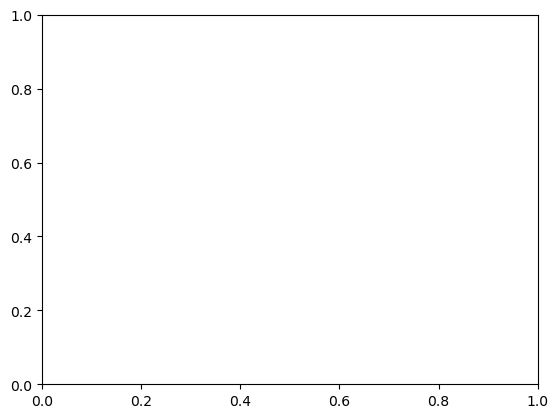

In [33]:
%%time
writer = PillowWriter(fps=5) 
animation_test_tobac.save("anima1-10.gif", writer=writer, dpi=200)

<h1 style="color:red;  text-align: center;">END OF TRACK</h1>